# Jeopardy Scraping

Script to scrape J! Archive to find Daily Double locations and show in a heatmap.

In [5]:
from bs4 import BeautifulSoup
import urllib.request
from collections import Counter

normal_locations = []
double_locations = []

#Scrape J Archive for historical games
#Using games from 2004 - current

#7068 is most current game in database as of 7-3-21
for x in range(1, 7068):
    j1 = 'http://www.j-archive.com/showgame.php?game_id='
    link = j1 + str(x)
    page = urllib.request.urlopen(link, timeout=80)
    html = page.read()
    soup = BeautifulSoup(html)
    
    cnt = 0
    for item in soup.find_all('td', 'clue_value_daily_double'):
        e = item.parent.find_all('td')
        e = e[0].get('id')
        if cnt == 0:
            e = e[7:11].replace('_','') #creates pair ex: 23 showing location (here column 2 row 3)
            normal_locations.append(e)
        else:
            e = e[8:11].replace('_','')
            double_locations.append(e)
        
        cnt = cnt + 1
    
    if x % 100 == 0:
        print(f'Iteration: {x}')

In [188]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [19]:
#create dictionary of index:number of daily doubles
double_locations = dict(Counter(double_locations)) 
normal_locations = dict(Counter(normal_locations))

#adding missing data
normal_locations['21'] = 0
normal_locations['41'] = 0

#sorting dictionaries
normal_locations = dict(sorted(normal_locations.items(), key=lambda x: x[0].lower())) 
double_locations = dict(sorted(double_locations.items(), key=lambda x: x[0].lower()))

In [285]:
# Saving data
import json

with open('normal_locations.json', 'w') as f:
    json.dump(normal_locations, f)

with open('double_locations.json', 'w') as f:
    json.dump(double_locations, f)

In [4]:
# Loading data
import json

with open('normal_locations.json') as f:
    normal_locations = json.load(f)
    
with open('double_locations.json') as f:
    double_locations = json.load(f)

In [287]:
#Create heatmap when passing frequency dict

def create_heatmap(frequency_dict, double = False):
    df = pd.DataFrame({'Location':list(frequency_dict.keys()), 'Values':list(frequency_dict.values())})
    
    Xcols = []
    Yrows = []
    for x in range(30): #30 = 6x5
        Xcols.append(df['Location'][x][0])
        Yrows.append(df['Location'][x][1])
    
    df['Xcols'] = Xcols
    df['Yrows'] = Yrows
    
    result = df.pivot(index='Yrows', columns='Xcols', values='Values') #create matrix of data
    result.columns = ['Category 1', 'Category 2', 'Category 3', 'Category 4', 'Category 5', 'Category 6']
    
    if double: 
        result.index = ['$400', '$800', '$1200', '$1600', '$2000']
        title = 'Double Jeopardy! Daily Double Heatmap'
    else: 
        result.index = ['$200', '$400', '$600', '$800', '$1000']
        title = 'Jeopardy! Daily Double Heatmap'
    
    dd_hits = np.asarray(list(frequency_dict.values())).reshape(6,5).swapaxes(0,1) #USE THIS FOR LABELING
    dd_index = np.asarray(list(frequency_dict.keys())).reshape(6,5).swapaxes(0,1)
    
    total_dd = sum(dd_hits.flatten())
    
    labels = (np.asarray([f'{value} \n {round((value / total_dd)*100, 2)}%' for value in dd_hits.flatten()])).reshape(5,6)
    
    fig, ax = plt.subplots(figsize=(12,7))
    
    
    plt.title(title, fontsize = 20)
    ax.tick_params(axis='both', which='major', labelsize=12, labelbottom=False, bottom=False, top=True, labeltop=True)
    
    sns.heatmap(result, fmt="", annot=labels, cmap='Blues', linewidths=0.3, ax=ax)
    plt.yticks(rotation=0)

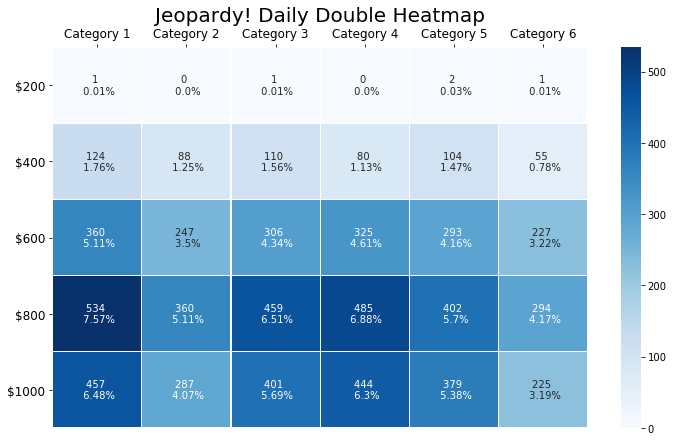

In [288]:
create_heatmap(normal_locations)

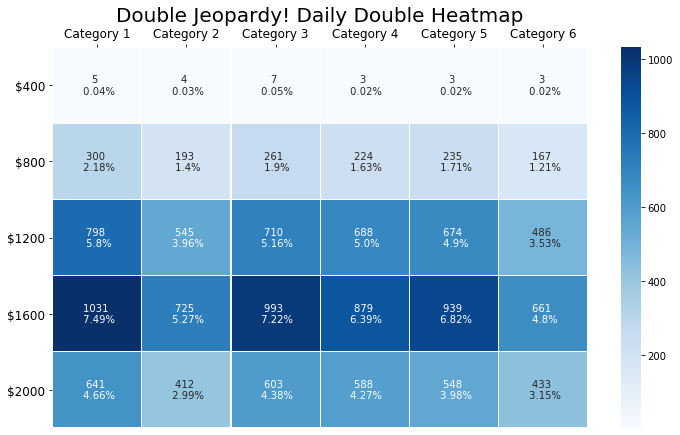

In [289]:
create_heatmap(double_locations, double=True)